# DNN

## Objetivos
- Aprender a cargar datos de un archivo CSV en un DataFrame de Pandas.
- Comprender la importancia del preprocesamiento de datos en el entrenamiento de redes neuronales.
- Crear nuestro primer modelo de una red neuronal.
- Evaluar el modelo y realizar predicicones.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import os
import pandas as pd
import numpy as np

from IPython import display
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0


## Base de datos : central eléctrica ciclo combinado

El conjunto de datos contiene 9568 puntos de datos recogidos de una central eléctrica de ciclo combinado a lo largo de 6 años (2006-2011), con el objetivo de construir una red neuronal para redecir la potencia eléctrica generada.

![CCP.jpg](attachment:CCP.jpg)

La potencia de las turbinas de gas depende principalmente de los parámetros ambientales (temperatura ambiente, presión atmosférica y humedad relativa), pero también está relacionada con el vacío en el escape de la turbina de vapor.

Esta base de datos está formada por mediciones horarias de:
- Temperatura (T) en el rango 1,81°C y 37,11°C,
- Presión ambiente (PA) en el rango 992,89-1033,30 milibar,
- Humedad relativa (HR) en el intervalo de 25,56% a 100,16%.
- Vacío de escape (V) en el rango 25,36-81,56 cm Hg
- Producción horaria neta de energía eléctrica (EP) 420,26-495,76 MW

Los datos están disponibles en [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

El primer paso es cargar los datos desde el archivo `CCP.csv` a un `DataFrame` utilizndo la librería **pandas**.

In [2]:
if 'google.colab' in str(get_ipython()):
  data_path = 'https://raw.githubusercontent.com/cursos-COnCEPT/curso-tensorflow/refs/heads/main/CCP.csv'
else:
  data_path = os.getcwd() + '\\CCP.csv'

dataset = pd.read_csv(data_path, sep=',')
dataset.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,478.773301
1,23.64,58.49,1011.40,74.20,444.043300
2,29.74,56.90,1007.15,41.91,437.053300
3,19.07,49.69,1007.22,76.79,451.383301
4,11.80,40.66,1017.13,97.20,466.136700


En algunos casos, resulta interesante explorar los datos antendiendo a medidas estadísticas.

In [3]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.400863
std,7.452473,12.707893,5.938784,14.600269,17.127308
min,1.810000,25.360000,992.890000,25.560000,419.863300
25%,13.510000,41.740000,1009.100000,63.327500,439.849975
50%,20.345000,52.080000,1012.940000,74.975000,451.508350
75%,25.720000,66.540000,1017.260000,84.830000,468.556699
max,37.110000,81.560000,1033.300000,100.160000,497.466700


Así como representar los datos de forma gráfica.

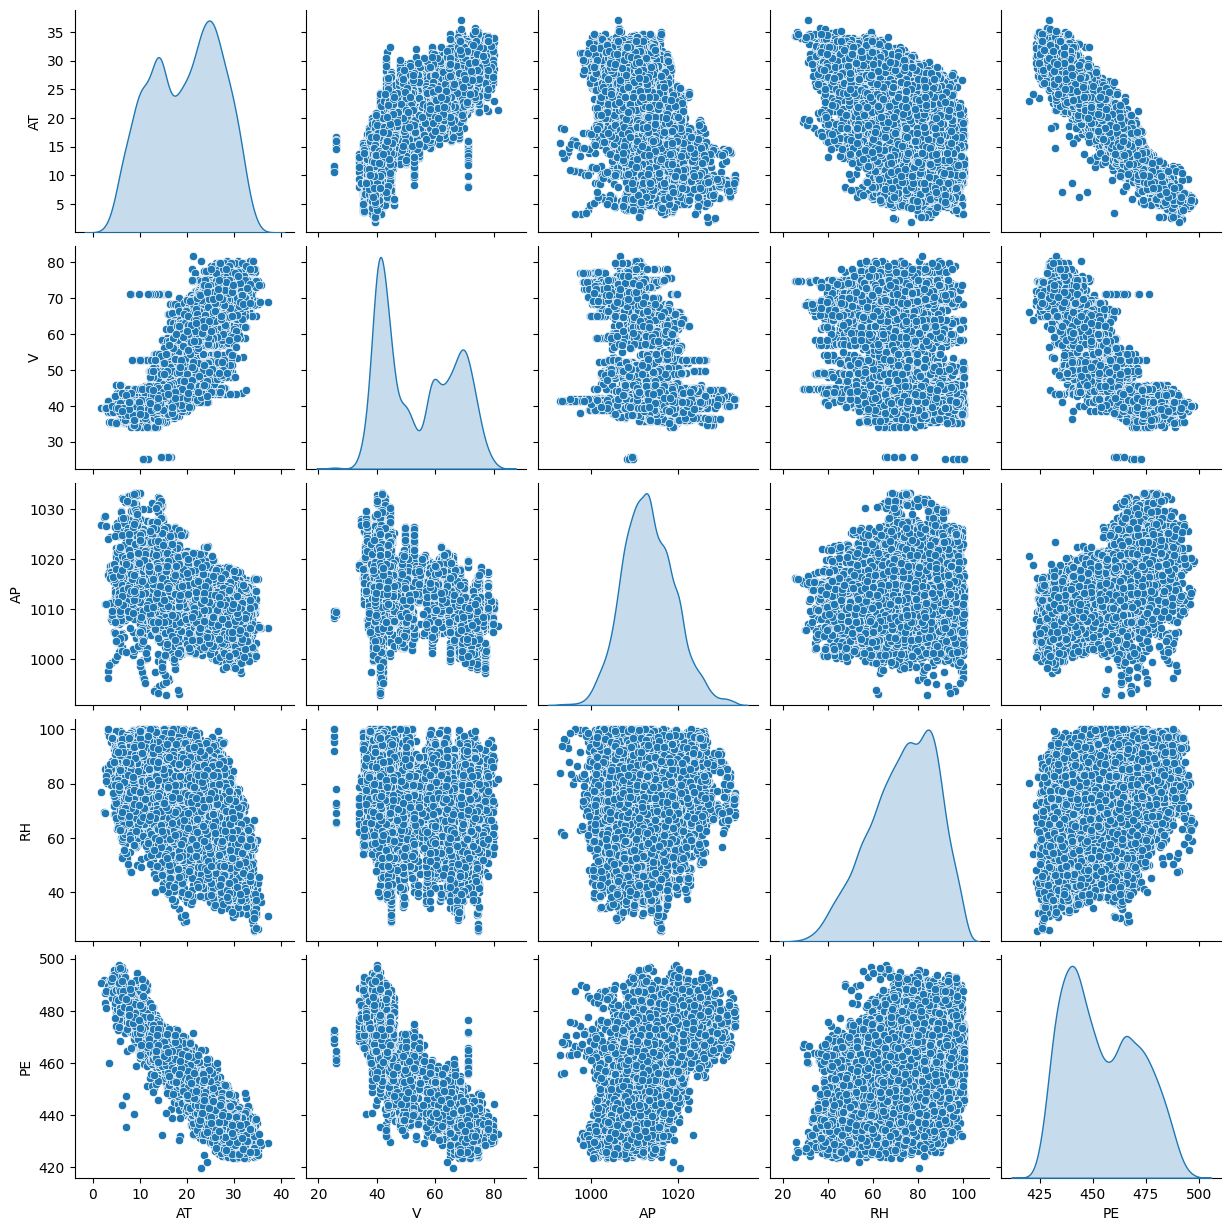

In [4]:
import seaborn as sns

sns.pairplot(dataset, diag_kind='kde')

## Preprocesamiento de datos
### 1 - División o *train-test-validation split*

Nuestro objetivo es crear un modelo que generalice bien a los datos no vistos y no simplemente que se ajuste perfectamente a algunos datos vistos. Por este motivo debemos asegurar que al dividir los datos, los conjunto de `test`sea lo más parecido a los datos futuros en los que se quiere aplicar el modelo.

En este caso, basta con dividir nuestro `dataset` de forma aleatoria. Sin embargo, hay situaciones más complejas en las que hay que tener cuidado con cómo se hace el reparto. Puedes aprender más sobre el *stratified splitting* [aquí](https://scikit-learn.org/stable/modules/cross_validation.html#stratification).

In [6]:
train_ratio = .7
test_ratio = .15
val_ratio = .15

# PASO 1: Separar la fracción que se utilizará para TEST
X = dataset.sample(frac=train_ratio+val_ratio, # Fracción de puntos del dataset que se utilizan para TRAIN + VALIDACIÓN
                         random_state=0)
X_test = dataset.drop(X.index) # Separar del dataset original los puntos que se utilizarán para TEST

# PASO 2: Del conjunto restante, separar la fracción que irá a TRAIN de la de VALIDACIÓN
X_train = X.sample(frac= train_ratio/(train_ratio+val_ratio), random_state=0) # TODO
X_val = X.drop(X_train.index)# TODO

### 2- Separación inputs y outputs

In [7]:
y_train = X_train.pop('PE')
y_test = X_test.pop('PE')# TODO
y_val = X_val.pop('PE')# TODO

### 3 - Escalado
El análisis estadístico ha sido útil para identificar cómo las variables de entrada tienen diferentes escalas, lo cual puede afectar al proceso de entrenamiento, ya que las variables que se mueven en un rango más amplio tienen mayor impacto sobre el modelo.

Para evitar que esto ocurra, es recomendable escalar los datos. Para este ejemplo, vamos a utilizar la función `MinMaxScaler` del paquete **sklearn**. Internamente, esta función realiza la siguiente operación:
```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [8]:
from sklearn.preprocessing import MinMaxScaler

Primero inicializamos nuestra función de escalado y después llamamos al comando `fit` para obtener los parámetros de la función, esto es, los valores mínimo y máximo de cada variable de entrada en el training set.

In [9]:
# Crear un objeto de la clase MinMaxScaler
scaler = MinMaxScaler()# TODO

# Llamar a la funcion fit con los datos de entrenaiento
scaler.fit(X_train)

MinMaxScaler()

**Atención:** el escalado no se aplica a los outputs. ([*Should you scale target values in a regression problem?*](https://www.kaggle.com/discussions/questions-and-answers/181908)).

A continuación, escalamos los datos.

In [11]:
X_train_nondim = scaler.transform(X_train)
X_test_nondim = scaler.transform(X_test)
X_val_nondim = scaler.transform(X_val)

#### Ejercicio - leer la documentación
Para aprender sobre *machine learning* o programación en general, es fundamental saber manejarse con la documentación de las diferentes herramientas y extraer la información que nos interesa.

Visita la [web de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) y contesta la siguiente pregunta:
- ¿Cuáles son los valores de `X.min` y `X.max` que se utilizan ara escalar los datos?

In [ ]:
# Completa con tu código aquí
min_values =
max_values =

# print('Los valores mínimos y máximos para cada variable son:')
for i, col in enumerate(X_train.columns):
    print(f'{col}: {min_values[i]} - {max_values[i]}')

Es importante conocer qué valores se han utilizado para hacer el escalado de los datos de entrenamiento porque luego deberán aplicarse los mismos a cualquier otro dato que se alimente al modelo.

## Modelo

### 1 - Definición del modelo
Aquí vamos a utilizar un modelo secuencial con 2 capas internas con 32 y 16 neuronas, respectivamente, seguidas de una capa de salida que devuelve un único valor, el de la potencia eléctrica producida. Para las capas internas, aplica funciones de activación tipo ReLU y ten en cuenta que en problemas de regresión no suele aplicarse ninguna función de activación en la *output layer*.

Como es un modelo relativamente sencillo, se va a entrenar durante 100 épocas,

In [12]:
# Crea una variable con el número de entradas del modelo
num_inputs = X_train.shape[1]

# Crea una lista con el número de neuronas en cada capa oculta
num_hidden_neurons = [32,16]

# Crea una variable con el número de salidas del modelo
num_outputs = 1

# Crea una variable con el número de ÉPOCAS (número de veces que se recorre el conjunto de datos de entrenamiento)
EPOCHS = 100

# Crea una variable con el tamaño del BATCH (número de puntos a utilizar para actualizar los pesos en cada iteración del algoritmo de optimización)
BATCH_SIZE = 256

# Crea una variable con el número de puntos en el conjunto de datos de entrenamiento
N_TRAIN = len(X_train)

# Crea una variable con el número de pasos por época (PISTA: cociente de la división entre N_TRAIN y el tamaño del BATCH)
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

Los modelos `Sequential` se definen a partir de una lista de capas o `layers` siguiendo la siguiente estructura:
```python
model = keras.Sequential(
    [   layers.InputLayer(shape=DIMENSIONES_INPUT_LAYER, name = "nombre0"),
        layers.Dense(NUM_NEURONAS_1, activation="nombre_act_fcn", name="nombre1"),
        (...)
        layers.Dense(NUM_NEURONAS_1, activation="nombre_act_fcn", name="nombreN-1"),
        layers.Dense(NUM_OUTPUT_VAR, name="nombreN"),
    ]
)
```
En esta plantilla se han utilizado solo capas densas o 'Dense', pero podría probarse con cualquiera de los tipos disponibles en la [Keras Layers API](https://keras.io/api/layers/).

In [13]:
model = keras.Sequential([
    layers.InputLayer(shape=[num_inputs,], name='INPUT'),
    layers.Dense(32, activation='relu', name='HIDDEN1'),
    layers.Dense(16, activation='relu', name='HIDDEN2'),
    layers.Dense(1, name='OUTPUT'),
])

### 2-Compilar el modelo
Antes de entrenar el modelo, hay que indicarle qué algoritmo de optimización utilizar y cuál es la función objetivo a minimizar. Este paso se conoce como **compilar** y se lleva a cabo llamando a la función `compile`.
```python
model.compile(  loss= my_loss_function,
                optimizer= my_optimizer ,
                metrics= list_of_metrics_to_evaluate)
```
Al tratarse de un problema de regresión, se utilizará el error cuadrático medio (MSE) como función objetivo y, durante el entrenamiento, se registrarán también el error absoluto medio (MAE). Para resolver el problema, Adam es uno de los optimizadores más utilizados.

#### ¿Puede varíarse el *learning rate*?

Sí, de hecho, la mayoría de modelos convergen mejor cuando se disminuye el *learning rate* de forma gradual durante el entrenamiento.

Para modular cómo varía el *learning rate* se utilizan funciones llamadas *learning rate schedules*. Existen diversos *schedules* ya implementados en TensorFlow, entre los que vamos a utilizar [InverseTimeDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay).


In [14]:
# Definir un valor inicial para el learning rate
initial_learning_rate = 0.01

# Definir el learning rate schedule
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps=STEPS_PER_EPOCH*20,
    decay_rate=1,
    staircase=True)

# Definir el optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

El código de arriba crea un `tf.keras.optimizers.schedules.InverseTimeDecay` para disminuir el *learning rate* a la mitad pasadas las primeras 20 épocas, 1/3 a las 40, etc.

La siguiente celda simplemente permite visualizar el `lr_schedule` que hemos definido.

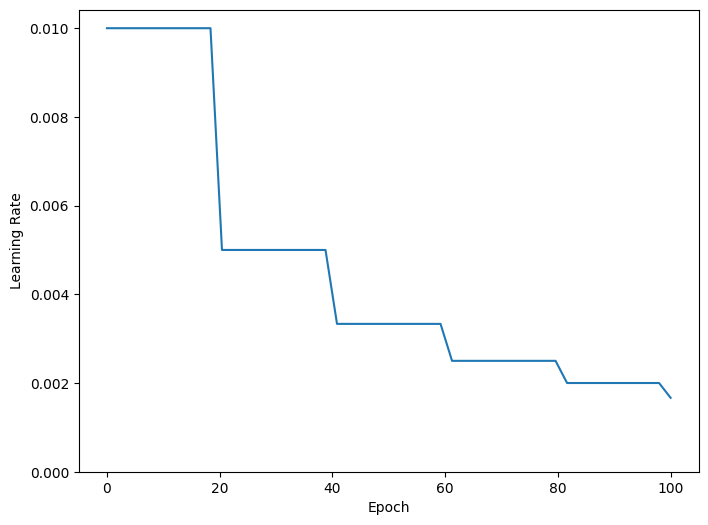

In [15]:
step = np.linspace(0,EPOCHS*STEPS_PER_EPOCH)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Finalmente, llamamos a la función `compile`.

In [16]:
model.compile(  loss= 'mse' , # Especifica una loss function adecuada para este problema,
                optimizer= optimizer, # Indica el optimizador a utilizar,
                metrics= ['mae'] ) # Escribe una lista con las métricas a utilizar para evaluar el modelo

Una vez construido, el método `summary` permite inspeccionar el modelo.

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ HIDDEN1 (Dense)                      │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HIDDEN2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OUTPUT (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Teóricamente, ya podríamos utilizar el modelo para hacer predicciones.

In [18]:
# Extrae un pequeño conjunto de 10 puntos de entrenamiento para hacer una predicción de prueba
example_batch = X_train_nondim[:10]
# Realiza una predicción con el modelo
example_result = model.predict(example_batch)

# Crea un DataFrame con los valores reales y los valores predichos
results_df = pd.DataFrame({
    'Real Values': y_train[:10].values,
    'Predicted Values': example_result.flatten()
})
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
   Real Values  Predicted Values
0   441.976699         -0.045282
1   439.116699         -0.014574
2   472.900000         -0.066023
3   423.473300          0.031553
4   461.176699         -0.025516
5   447.966700         -0.051236
6   453.200000         -0.065477
7   434.443301          0.040368
8   471.243300         -0.170025
9   484.753301         -0.038771


### 3 - Entrenamiento
Aunque el modelo parece funcionar y da un resultado de la forma y tipo esperados, las predicciones no se ajustan a los valores esperados. Esto se debe a que todavía no está entrenado, es decir, hay que optimizar los valors de los pesos o `weights` de la red neuronal.

In [19]:
history = model.fit(X_train_nondim , # Completa con el conjunto de inputs de entrenamiento ya normalizadas
                    y_train , # Completa con las outputs del conjunto de datos de entrenamiento
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data =  (X_val_nondim, y_val) , # Completa con el conjunto de inputs de validación ya normalizadas en forma de tupla (X,y)
                    verbose=1, # 0: sin información, 1: con información
             )

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 204212.0312 - mae: 451.5339 - val_loss: 179490.3125 - val_mae: 423.2247
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 152771.5781 - mae: 387.8939 - val_loss: 37256.2109 - val_mae: 188.4931
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17488.0801 - mae: 114.3759 - val_loss: 5100.8013 - val_mae: 60.6342
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4009.8022 - mae: 52.9283 - val_loss: 3034.6379 - val_mae: 46.1972
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3005.9797 - mae: 45.9860 - val_loss: 2678.9929 - val_mae: 43.1571
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2643.3926 - mae: 42.3795 - val_loss: 2383.5715 - val_mae: 40.4767
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2371.2324 - mae: 40.0468 - val_loss: 2115.7461 - val_mae: 37.4604
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2113.3352 - mae: 37.2978 - val_loss: 1911.4244 - val

KeyError: 'mse'

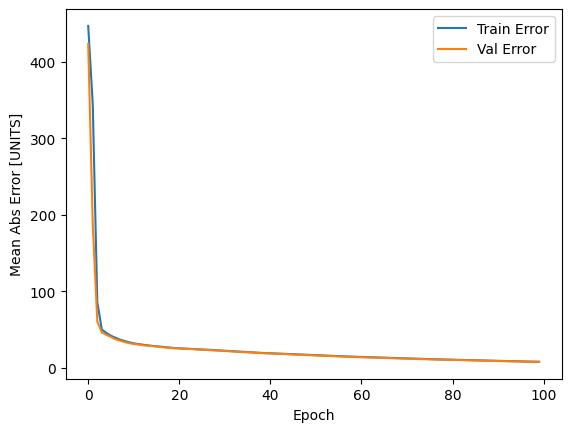

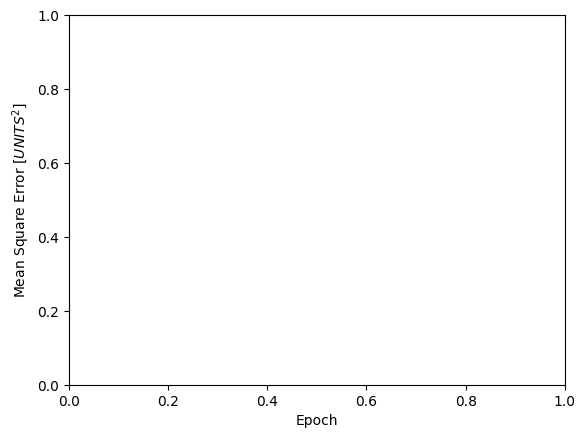

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [UNITS]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$UNITS^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Validation Error')
  plt.legend()
  plt.show()

plot_history(history)

### 3 - Evaluación

Obtén el valor de la *loss fucntion*, así como de las métricas monitoreadas durante el entrenamiento utilizando el comando `evaluate`.
```python
    loss, metric1, ..., metricN = model.evaluate(X,y,verbose=0)
```

In [22]:
loss, mae = model.evaluate(X_test_nondim, y_test, verbose=2)

print("MAE en test: {:5.2f} MW".format(mae))

45/45 - 0s - 8ms/step - loss: 101.3373 - mae: 7.9499
MAE en test:  7.95 MW


### 4 - Realizar predicciones

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(499.0369555664062, 408.02393310546876, 499.0369555664062, 408.02393310546876)

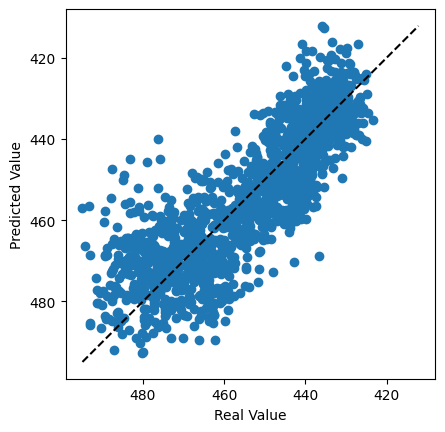

In [23]:
test_predictions = model.predict(X_test_nondim).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
p1 = max(max(test_predictions), max(y_test))
p2 = min(min(test_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], '--k')
plt.xlim([p1,p2])
plt.ylim([p1,p2])
plt.axis('square')

También podemos visualizar la distribución de errores.

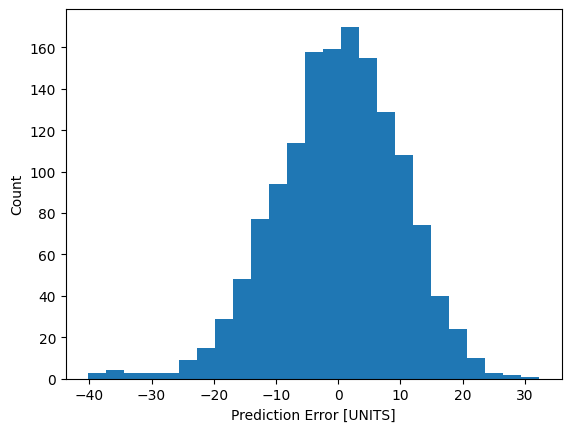

In [24]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [UNITS]")
_ = plt.ylabel("Count")

## Conclusiones

Con este ejemplo hemos aprendido:

* El error cuadrático medio (MSE) es una *loss function* muy utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Otra métrica muy común para evaluar el modelo es el error absoluto medio (MAE).
* Cuando las *inputs* tienen valores con diferentes rangos, deben aplicarse técnicas de escalado.

Con este modelo se va a aprender a crear una red neuronal
con otro ejemplo se va a ver el overfitting + early stopping
con otro diferente el hyperparam tunning
se vuelve a este si da tiempo para el concurso